In [1]:
from googleapiclient import discovery
from googleapiclient.errors import HttpError
import json
import pandas as pd
import numpy as np
import time
import spacy
from spacy.matcher import PhraseMatcher
import en_core_web_sm
nlp = en_core_web_sm.load()

with open('api_key.txt', 'r') as file:
    API_KEY = file.read().rstrip()

NER = spacy.load("en_core_web_sm")

phrase_matcher = PhraseMatcher(NER.vocab)


/Users/lucasrosenblatt/opt/miniconda3/envs/perspective/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Import Reddit CSV as Dataframe
Subsampled from https://www.kaggle.com/datasets/ehallmar/reddit-comment-score-prediction (4 mil -> 36k).

All examples should include names, pronouns or both.

In [2]:
def regen(seed=56):
    df1 = pd.read_csv('comments_negative.csv')
    df2 = pd.read_csv('comments_positive.csv')
    df_whole = pd.concat([df1,df2])

    binary_contains_columns = ['text_contains_NER','parent_text_contains_NER','text_contains_pronoun','parent_text_contains_pronoun']
    columns_to_keep = ['text','score','parent_text','parent_score']
    all_columns = columns_to_keep + binary_contains_columns 
    for col in binary_contains_columns:
        df_whole[col] = 0

    sub_df = df_whole.sample(frac=0.01, random_state=seed)

    def check_row_for_NER_and_pronouns(row):
        if row['text'].isupper():
            return row

        parsed = NER(row['text'])
        parsed_parent = NER(row['parent_text'])
        if len(parsed.ents) > 0:
            for word in parsed.ents:
                if word.label_ == 'PERSON':
                    row['text_contains_NER'] = 1
        if len(parsed_parent.ents) > 0:
            for word in parsed_parent.ents:
                if word.label_ == 'PERSON':
                    row['parent_text_contains_NER'] = 1
        counter = 0 
        for word in parsed:
            if word.pos_ == 'PRON':
                counter += 1
            if counter > 1:
                row['text_contains_pronoun'] = 1
                continue
        counter = 0 
        for word in parsed_parent:
            if word.pos_ == 'PRON':
                counter += 1
            if counter > 1:
                row['parent_text_contains_pronoun'] = 1
                continue
        return row

    data = sub_df.apply(lambda row: check_row_for_NER_and_pronouns(row), axis=1)

    data = data[(data['text_contains_NER'] == 1) | 
         (data['parent_text_contains_NER'] == 1) | 
         (data['text_contains_pronoun'] == 1) | 
         (data['parent_text_contains_pronoun'] == 1)]
    data = data[all_columns]

    data.to_csv('reddit_comments.csv')
    return data

# NOTE: Data can only be regend if comments_negative, comments_positive csvs are in directory
data = pd.read_csv('reddit_comments.csv')
# data = regen()

In [3]:
data

,Unnamed: 0,text,score,parent_text,parent_score,text_contains_NER,parent_text_contains_NER,text_contains_pronoun,parent_text_contains_pronoun
0,1039091,Then you spend the next few minutes screaming ...,113,"The F.E.A.R games. Rounding a corner, hearing ...",101.0,0.0,0.0,1.0,1.0
1,1667861,But the national anthem isn't part of the mili...,76,I was surprised how militarist the USA really ...,15.0,0.0,1.0,0.0,1.0
2,1187133,Always was easy against the computer. Half th...,101,Play the small islands maps.\n\nColonise. Ever...,365.0,0.0,1.0,0.0,0.0
3,317042,The best way he can show his wife he loves her...,279,"I'm not pregnant, and I'm also a male. My lunc...",376.0,0.0,0.0,1.0,1.0
4,1458923,Well the crazy guy went and shot him.,-8,So it's really his fault that a crazy guy atta...,3.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
32560,1035898,"Yeah, I've worked in childcare for ten years a...",113,"Yeah, it's always a bit of a gamble to badmout...",258.0,0.0,0.0,1.0,1.0
32561,1738081,Huh? I'm not hating or being a fanboy. I'm say...,-7,"And here, everyone, is what we call a fanboy. ...",8.0,0.0,0.0,1.0,1.0
32562,1332570,Liek dis if u cry everytim,-9,Have you seen the comic that (I believe) origi...,204.0,0.0,0.0,0.0,1.0
32563,1552465,Congratulations on your baby girl.\n\nedit: Wo...,81,I'm adopted and have even less info on my biol...,156.0,0.0,0.0,1.0,1.0


### Example Analysis
Here we run an example analysis on a subset of our data.

A more complete analysis will be run for the final version (we abbreviate here as it is expensive to run)

In [152]:
NER_text = data[data['text_contains_NER'] == 1][['text','score']]
NER_parent_text = data[data['parent_text_contains_NER'] == 1][['parent_text','parent_score']]
NER_parent_text = NER_parent_text.rename(columns={"parent_text": "text", "parent_score": "score"})
NER_df = pd.concat([NER_text, NER_parent_text])
NER_df = NER_df.sample(frac=0.01)



In [153]:
NER_bank = ['Emily','Greg','Jamal','Lakisha']
for c in NER_bank:
    NER_df[c + '_text'] = ''
    # NER_df[c + '_score'] = 0

phrases = NER_bank
patterns = [NER(n) for n in phrases]
phrase_matcher.add('names', None, *patterns)

def create_NER_examples(row, name):
    try:
        # TODO: Analysis
        found = False
        t = row['text']
        ner = NER(row['text'])
        for word in ner.ents:
            if word.label_ == 'PERSON':
                t = t.replace(word.text, name)
                if not found:
                    for sent in NER(t).sents:
                        if not found:
                            for match_id, start, end in phrase_matcher(NER(sent.text)):
                                
                                if NER.vocab.strings[match_id] in ["names"]:
                                    row[name + '_text'] = sent.text
                                    found = True
                                    break
                        else:
                            break
                    else:
                        break
                            
    except:
        print(row['text'])
    return row

for name in NER_bank:
    NER_df = NER_df.apply(lambda row: create_NER_examples(row, name), axis=1)

In [154]:
NER_df

,text,score,Emily_text,Greg_text,Jamal_text,Lakisha_text
6593,I'd say we are paying too little for games lik...,127.0,I'd say we are paying too little for games lik...,I'd say we are paying too little for games lik...,I'd say we are paying too little for games lik...,I'd say we are paying too little for games lik...
21192,It's mother had been killed so he brought it u...,65.0,He calls it Emily and I call it Rikimaru.,He calls it Greg and I call it Rikimaru.,He calls it Jamal and I call it Rikimaru.,He calls it Lakisha and I call it Rikimaru.
4454,"Halle Berry's tits, so everybody wins.",92.0,"Emily tits, so everybody wins.","Greg tits, so everybody wins.","Jamal tits, so everybody wins.","Lakisha tits, so everybody wins."
22030,Jamie Foxx has kids too. So does Christoph Wal...,97,Emily has kids too.,Greg has kids too.,Jamal has kids too.,Lakisha has kids too.
1486,"Sort of an Ironic thing to say on reddit, no? ...",6.0,People on here always advocating voting the ca...,People on here always advocating voting the ca...,People on here always advocating voting the ca...,People on here always advocating voting the ca...
...,...,...,...,...,...,...
6051,now your calling something that disagrees with...,-7,your calling something that disagrees with you...,your calling something that disagrees with you...,your calling something that disagrees with you...,your calling something that disagrees with you...
28262,I've always found the Dutch to be easy to spot...,133,When in groups they are easy to spot because y...,When in groups they are easy to spot because y...,When in groups they are easy to spot because y...,When in groups they are easy to spot because y...
7496,"Fuck Ron Paul?\n(Wonka Face)\nPlease, tell me ...",-20,Fuck Emily?\n,Fuck Greg?,Fuck Jamal?\n,Fuck Lakisha?
14588,&gt;*Everything sounds better in Latin.*\n\nEx...,196,*\n\nExcept Emily...,*\n\nExcept Greg...,*\n\nExcept Jamal,*\n\nExcept Lakisha...


In [85]:
# TODO: Pronouns replacement
pronoun_text = data[data['text_contains_pronoun'] == 1]['text']
pronoun_parent_text = data[data['parent_text_contains_pronoun'] == 1]['parent_text']

### Score Mapping
Here are the different scores that we may want to examine

In [155]:
score_type_map_full = {
    "toxicity_score": "TOXICITY",
    "identity_score": "IDENTITY_ATTACK",
    "insult_score": "INSULT",
    "threat_score": "THREAT",
    "sex_score": "SEXUALLY_EXPLICIT",
    "flirtation_score": "FLIRTATION"
}

score_type_map_toxicity = {
    "toxicity_score": "TOXICITY"
}

### Runner
Idea for future me: Pooling api keys to make the script run faster

In [156]:
client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

def score_row_NER(row, score_type_list, add_delay=False):
    if add_delay:
        time.sleep(2)
    try:
        score_type_attribute = {value: {} for value in score_type_list}
        analyze_request = {
            'comment': { 'text': row['text'] },
            'languages': ["en"],
            'requestedAttributes': score_type_attribute
        }
        response = client.comments().analyze(body=analyze_request).execute()

    except HttpError as err:
        if err.resp.status == 429:
            print('Quota limit exceeded')
            time.sleep(10)
            response = client.comments().analyze(body=analyze_request).execute()
        else:
            raise

    value_list = []
    
    for score_type in score_type_list:
        value_list.append(
            response['attributeScores'][score_type]['summaryScore']['value'])

    for name in NER_bank:
        if add_delay:
            time.sleep(2)
        try:
            score_type_attribute = {value: {} for value in score_type_list}
            analyze_request = {
                'comment': { 'text': row[name + '_text'] },
                'languages': ["en"],
                'requestedAttributes': score_type_attribute
            }
            response = client.comments().analyze(body=analyze_request).execute()

        except HttpError as err:
            if err.resp.status == 429:
                print('Quota limit exceeded')
                time.sleep(10)
                response = client.comments().analyze(body=analyze_request).execute()
            # else:
            #     raise

        for score_type in score_type_list:
            value_list.append(
                response['attributeScores'][score_type]['summaryScore']['value'])
    
    return tuple(value_list)

In [157]:
NER_df = NER_df.sample(frac=0.2)

In [158]:
# NOTE: Replace score_type_map_toxicity with score_type_map_full to run on all available toxicity scores
score_col_names = list(score_type_map_toxicity.keys())
score_type_list = list(score_type_map_toxicity.values())

results = NER_df.apply(lambda row: score_row_NER(
    row, 
    score_type_list=score_type_list, 
    add_delay=True), axis=1, result_type='expand')
results.columns = ['score','Emily_score','Greg_score','Jamal_score','Lakisha_score']


In [104]:
create_NER_examples(data.loc[305393], 'Jamal')['parent_text']

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_30877/20735409.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[name + '_text'] = t
/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_30877/20735409.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[name + '_text'] = t


"I don't normally advocate violence, but these particular type of Muslims? Fucking wipe them off the face of the earth. Do it now. They are nothing but an evil plague intent on barbaric ways of life and destroying anything that doesn't mesh with their ways. They do nothing but cause pain and suffering and hold back others who wish to better themselves. \n\nEdit: I can see my comments have polarized this thread. There are a lot of you upset by what I said, and I understand that. What you don't seem to get is that these are not a peaceful people. If they had their way, they'd plunge us all back into the dark ages where men rule women, homosexuals are beheaded, religious nuttery is the only law etc. These are not folks who worship peacefully at your local mosque. These are not rational people. They shoot 14 year old women in the face for seeking education. They destroy history and culture because it contradicts what they believe is true or right. They detonate car bombs in crowded markets

In [162]:
data.loc[522]['text']

'No. And in honor of the man who said it first and said it best, I call that the "Ron White Rule": If you\'ve seen one set of tits... you pretty much want to see the rest of \'em.'

In [159]:
results

,score,Emily_score,Greg_score,Jamal_score,Lakisha_score
522,0.733072,0.770403,0.811520,0.778266,0.834113
27650,0.116410,0.179565,0.240001,0.247060,0.173781
9847,0.695427,0.093753,0.051529,0.097945,0.037696
7382,0.717966,0.179710,0.329371,0.327617,0.322458
28428,0.842559,0.091277,0.109158,0.147205,0.084121
765,0.888247,0.815041,0.860626,0.860626,0.860626
20568,0.584254,0.553183,0.605050,0.587656,0.460011
28779,0.141898,0.119585,0.076588,0.110150,0.096796
21512,0.136925,0.108283,0.113671,0.184044,0.092546
8080,0.063378,0.079176,0.055132,0.107483,0.054562


In [163]:
NER_df.to_csv('toxicity_benchmark_scores.csv')

### Stats Calculation
Now that everything is in a nice dataframe, we can do some stats.

In [169]:
results.astype(np.float64)
results.mean(axis=0)

score            0.355373
Emily_score      0.232621
Greg_score       0.252179
Jamal_score      0.273867
Lakisha_score    0.229360
dtype: float64

In [170]:
results.std(axis=0)

score            0.299075
Emily_score      0.234397
Greg_score       0.253369
Jamal_score      0.234584
Lakisha_score    0.249908
dtype: float64

## For Data Profiling

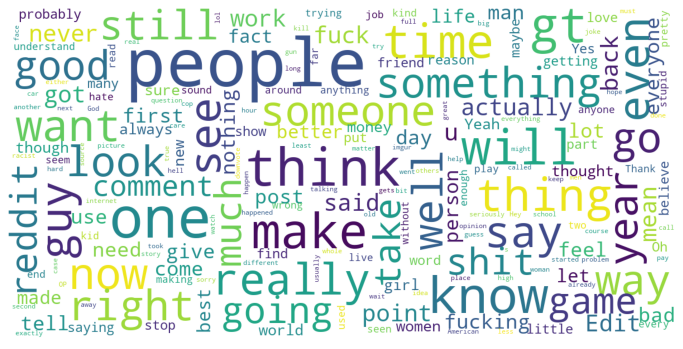

In [180]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(" ".join(list(data['text'].sample(frac=0.1).to_numpy())))

In [ ]:
import nlp_profiler.core as nlpprof

new_text_column_dataset = nlpprof.apply_text_profiling(data.sample(frac=0.01), 'text')

In [6]:
new_text_column_dataset

,text,sentences_count,characters_count,spaces_count,count_words,duplicates_count,chars_excl_spaces_count,emoji_count,whole_numbers_count,alpha_numeric_count,...,sentiment_polarity_summarised,sentiment_subjectivity_score,sentiment_subjectivity,sentiment_subjectivity_summarised,spelling_quality_score,spelling_quality,spelling_quality_summarised,ease_of_reading_score,ease_of_reading_quality,ease_of_reading_summarised
16965,"The mum has the option, and this is not a fair...",8,841,164,167,33,677,0,0,650,...,Negative,0.487500,Objective/subjective,Objective/subjective,0.967914,Good,Good,76.05,Fairly Easy,Easy
2226,It's the bleach!,1,16,2,4,0,14,0,0,12,...,Neutral,0.000000,Very objective,Objective,0.600000,Bad,Bad,119.19,Very Easy,Easy
31948,Are you arguing it didn't happen?,1,33,5,7,0,28,0,0,26,...,Neutral,0.000000,Very objective,Objective,0.875000,Bad,Bad,56.93,Fairly Difficult,Difficult
32218,&gt;In a real society this doesn't happen\n\nFTFY,1,47,6,10,0,41,0,0,36,...,Positive,0.300000,Pretty objective,Objective,0.750000,Bad,Bad,46.44,Difficult,Difficult
2329,So the time to decide what to do with the buil...,3,109,21,21,4,88,0,0,80,...,Neutral,0.000000,Very objective,Objective,0.960000,Good,Good,98.21,Very Easy,Easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13492,Pathetic. He's still a human being. Get over y...,3,82,12,14,2,70,0,0,66,...,Negative,0.650000,Pretty subjective,Subjective,0.941176,Pretty good,Good,56.42,Fairly Difficult,Difficult
15314,and yet another case of religious people using...,4,344,60,66,14,284,0,0,263,...,Negative,0.469048,Objective/subjective,Objective/subjective,0.923077,Pretty good,Good,84.47,Easy,Easy
27604,You're an idiot. This is what he said:\n\n“We...,7,490,85,87,23,405,0,1,375,...,Neutral,0.341667,Pretty objective,Objective,0.927273,Pretty good,Good,76.22,Fairly Easy,Easy
6811,"IKR! Personally, the Op strikes me as one of t...",5,522,101,102,19,421,0,0,407,...,Positive,0.486111,Objective/subjective,Objective/subjective,0.903509,Pretty good,Good,71.48,Fairly Easy,Easy
